In [28]:
import pathlib

import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
device

device(type='cpu')

In [30]:
device = torch.device('cpu')

In [31]:
n_particles = 250

r = torch.rand((2,n_particles)).to(device)
v = torch.rand((2,n_particles)).to(device)
# m = torch.ones((n_particles, )).to(device)
m = torch.ones((n_particles, )).to(device) * (10 ** (-5))
m[0] = 2.5 * 10 ** (-5)
m[1] = 2.5 * 10 ** (-5)

l_0 = 0.1

frames_c = 500

In [32]:
ids = torch.arange(n_particles)

In [33]:
ids_pairs = torch.combinations(ids,2).to(device)

Формула расчета скорости при столкновении:
$v_1^{(new)} = v_1 - \langle \frac{2m_2}{m_1 + m_2} (v_1 - v_2), r_1 - r_2 \rangle \cdot \frac{r_1 - r_2}{{\lVert r_1 - r_2 \rVert}^2}$
$v_2^{(new)} = v_2 - \langle \frac{2m_1}{m_1 + m_2} (v_1 - v_2), r_1 - r_2 \rangle \cdot \frac{r_1 - r_2}{{\lVert r_1 - r_2 \rVert}^2}$

In [34]:
def get_deltad2_pairs(r, ids_pairs):
    dx = torch.diff(torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T).squeeze()
    dy = torch.diff(torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T).squeeze()
    return dx**2 + dy**2

def compute_new_v(v1, v2, r1, r2, m1, m2):
    # v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    # v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    
    m_s = m1 + m2
    dr = r1 - r2
    dr_norm_sq = torch.norm(dr, dim=0) ** 2
    # print(f"{v1.shape}")
    # print(f"{dr_norm.shape=}")
    # v1new = v1 - torch.dot((2*m2/m_s)*v1 + (m1 - m2)/m_s * v2, dr) * dr / dr_norm
    # v2new = v2 - torch.dot((2*m1/m_s)*v2 + (m2 - m1)/m_s * v1, dr) * dr / dr_norm
    
    v1new = v1 - (torch.sum((2*m2/m_s) * (v1 - v2) * dr, axis=0) * dr) / dr_norm_sq
    v2new = v2 - (torch.sum((2*m1/m_s) * (v2 - v1) * dr, axis=0) * dr) / dr_norm_sq
    
    return v1new, v2new

def motion(r, v, id_pairs, ts, dt, d_cutoff, k: float = 50):
    rs = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    vs = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    # fs = torch.zeros((ts, r.shape[0])).to(device)
    fs = torch.zeros((ts, )).to(device)
    
    # Initial State
    rs[0] = r
    vs[0] = v
    for i in range(1,ts):
        ic = id_pairs[get_deltad2_pairs(r, ids_pairs) < d_cutoff**2]
        
        # v *= m
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]], m[ic[:,0]], m[ic[:,1]])
        # v /= m
        
        dr = r[:, 0] - r[:, 1]
        dr_sc = dr.norm()
        f = dr * (k * (1 - l_0/ dr_sc))
        v[:, 0] -= f * (dt / m[0]) 
        v[:, 1] += f * (dt / m[1])
        
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>1])
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -torch.abs(v[1,r[1]>1])
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        
        r = r + v*dt
        rs[i] = r
        vs[i] = v
        fs[i] = f.norm() * torch.sign(torch.dot(f, dr))
        
    return rs, vs, fs

In [35]:
ixr = r[0]>0.5 #right
ixl = r[0]<=0.5 #left

v[0][ixr] = -500
v[0][ixl] = 500

In [36]:
radius = 0.005
rs, vs, fs = motion(r, v, ids_pairs, ts=frames_c, dt=0.000008, d_cutoff=2*radius, k=100)

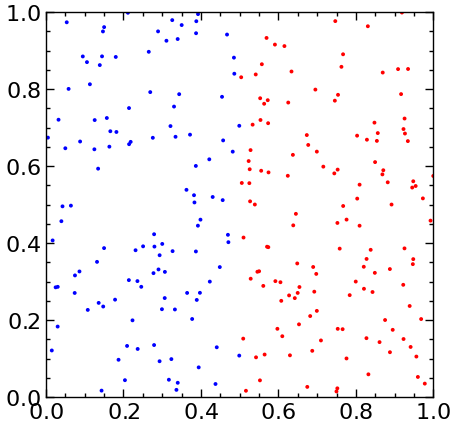

In [37]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
xred, yred = rs[0][0][ixr], rs[0][1][ixr]
xblue, yblue = rs[0][0][ixl],rs[0][1][ixl]
circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

In [38]:
# fig, ax = plt.subplots(1,1,figsize=(5,5))
# ax.clear()
# vmin = 0
# vmax = 1
# ax.set_xlim(0,1)
# ax.set_ylim(0,1)
# markersize = 2 * radius * ax.get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
# 
# spring, = ax.plot([], [], 'o', color='black', markersize=10*markersize)
# red, = ax.plot([], [], 'o', color='red', markersize=markersize)
# blue, = ax.plot([], [], 'o', color='blue', markersize=markersize)
# 
# def animate(i):
#     print(f"{i=}")
#     xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
#     xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
#     x_spring, y_spring = rs[i][0][0:2].cpu(), rs[i][1][0:2].cpu()
#     red.set_data(xred, yred)
#     blue.set_data(xblue, yblue)
#     spring.set_data(x_spring, y_spring)
#     return red, blue
# 
# # writer = animation.FFMpegWriter(fps=30)
# ani = animation.FuncAnimation(fig, animate, frames=1_000, interval=25, blit=True)
# path = pathlib.Path('./anim_brown_spring.gif')
# ani.save(path, dpi=100)

MovieWriter ffmpeg unavailable; using Pillow instead.


Process: 0/500
Process: 0/500
Process: 10/500
Process: 20/500
Process: 30/500
Process: 40/500
Process: 50/500
Process: 60/500
Process: 70/500
Process: 80/500
Process: 90/500
Process: 100/500
Process: 110/500
Process: 120/500
Process: 130/500
Process: 140/500
Process: 150/500
Process: 160/500
Process: 170/500
Process: 180/500
Process: 190/500
Process: 200/500
Process: 210/500
Process: 220/500
Process: 230/500
Process: 240/500
Process: 250/500
Process: 260/500
Process: 270/500
Process: 280/500
Process: 290/500
Process: 300/500
Process: 310/500
Process: 320/500
Process: 330/500
Process: 340/500
Process: 350/500
Process: 360/500
Process: 370/500
Process: 380/500
Process: 390/500
Process: 400/500
Process: 410/500
Process: 420/500
Process: 430/500
Process: 440/500
Process: 450/500
Process: 460/500
Process: 470/500
Process: 480/500
Process: 490/500
Process: 0/500


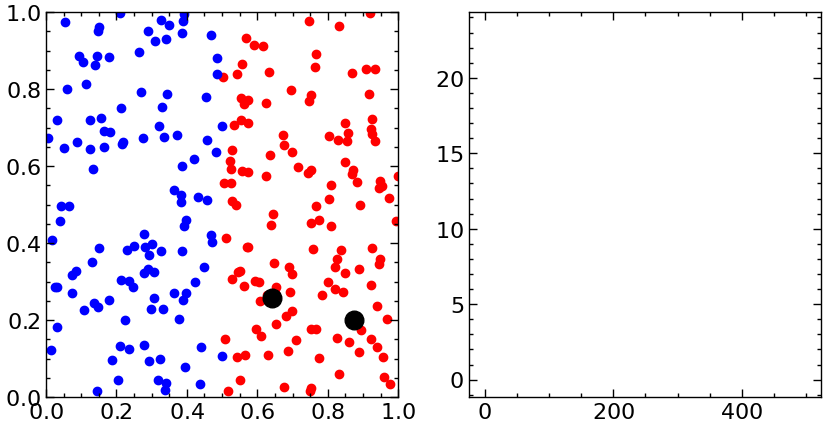

In [39]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].clear()
ax[1].clear()
vmin = 0
vmax = 1

# x_lim = (torch.min(rs[:, 0, :]).cpu() - 1, torch.max(rs[:, 0, :]).cpu() + 1)
# y_lim = (torch.min(rs[:, 1, :]).cpu() - 1, torch.max(rs[:, 1, :]).cpu() + 1)

x_lim, y_lim = (0, 1), (0, 1)

markersize = 2 * radius * ax[0].get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
spring, = ax[0].plot([], [], 'o', color='black', markersize=10*markersize)
red, = ax[0].plot([], [], 'o', color='red', markersize=markersize)
blue, = ax[0].plot([], [], 'o', color='blue', markersize=markersize)
force, = ax[1].plot([], [], color='k')

def animate(i):
    if i % 10 == 0:
        print(f"Process: {i}/{frames_c}")
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    x_spring, y_spring = rs[i][0][0:2].cpu(), rs[i][1][0:2].cpu()
    # red.set_data(xred, yred)
    # blue.set_data(xblue, yblue)
    # force.set_data(np.arange(1_000)[0:i], fs.norm(dim=1).cpu()[0:i])
    # return [(red, blue), force]

    ax[0].clear()
    ax[1].clear()

    ax[0].scatter(xred, yred, color='red')
    ax[0].scatter(xblue, yblue, color='blue')
    ax[0].scatter(x_spring, y_spring, color='black', s=5*(plt.rcParams['lines.markersize'] ** 2))
    # ax[1].plot(np.arange(10_000)[0:i], fs.norm(dim=1).cpu()[0:i])
    ax[1].plot(np.arange(10_000)[0:i], fs.cpu()[0:i])

    ax[0].set_xlim(x_lim)
    ax[0].set_ylim(y_lim)

# writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=frames_c, interval=25, blit=False)
path = pathlib.Path('./anim_brown_spring_mass.gif')
ani.save(path, dpi=100)

In [40]:
plt.plot(np.arange(frames_c), fs.norm(dim=1).cpu())

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
plt.rcParams['lines.markersize'] ** 2

In [ ]:
# force.min()

In [ ]:
from scipy import fft

In [ ]:
# force = fs.norm(dim=1).cpu().numpy()
force = fs.cpu()
force -= (force[-1] - force[0]) * np.linspace(0, 1, num=frames_c) + force[0]
force_fft = fft.fft(force)

In [ ]:
plt.plot(force_fft[10000:-10000])

In [ ]:
force[-1]

In [ ]:
torch.range(start=0, end=10)